In [13]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [14]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

from jax.scipy.special import gammaln

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [15]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


In [16]:
K = 2
N = 20
sigma = 0.01

alpha = 0.5 * jnp.ones(K,)

In [38]:
key, subkey = random.split(key)
pi = random.dirichlet(subkey, alpha)
print(pi)
print(jnp.sum(pi))

[0.25833617 0.74166383]
1.0


In [39]:
#pi = jnp.array([0.68387323, 0.31612677])

In [40]:
key, subkey = random.split(key)
z = random.categorical(subkey, jnp.log(pi), shape = (N,))
print(jnp.sum(z==0)/N)
print(jnp.sum(z==1)/N)

0.15
0.85


In [41]:
z

DeviceArray([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1], dtype=int64)

In [42]:
key, subkey = random.split(key)
x = random.normal(subkey, shape = (K,))
print(x)
#print(y.shape)

[-1.00354521 -0.02539831]


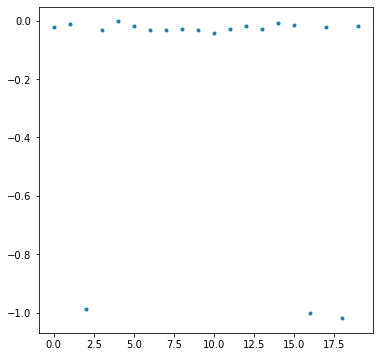

In [43]:
key, subkey = random.split(key)
y = x[z] + sigma * random.normal(subkey, shape = (N,))
plt.plot(y, '.')

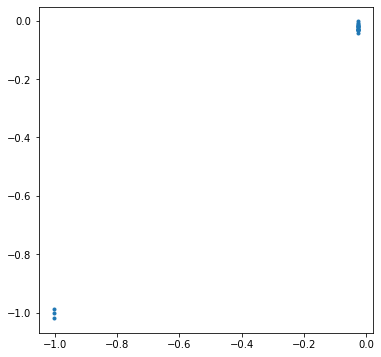

In [44]:
plt.plot(x[z], y, '.')

In [45]:
def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [46]:
calc_nik_jit(z).shape

(20, 2)

In [47]:
print(calc_nik_ki(z, 0, 13))
print(calc_nik_ki(z, 1, 13))
print(calc_nik_ki(z, 2, 13))

3
16
0


In [48]:
calc_nik_jit(z).shape

(20, 2)

In [49]:
pi

DeviceArray([0.25833617, 0.74166383], dtype=float64)

In [50]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

[[0.175 0.825]
 [0.175 0.825]
 [0.125 0.875]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.175 0.825]
 [0.125 0.875]
 [0.175 0.825]
 [0.125 0.875]
 [0.175 0.825]]


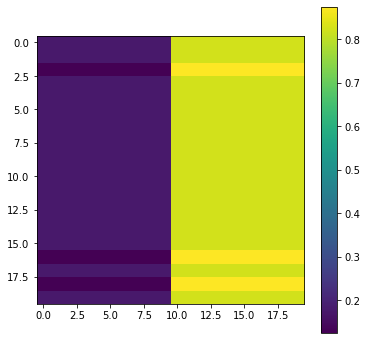

In [51]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   

print(probs_d)
#print(jnp.sum(probs_d, axis=1))

plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [52]:
n_ik_z.shape

(20, 2)

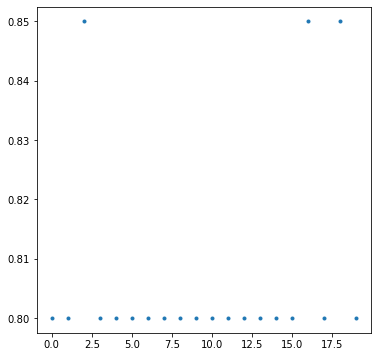

In [53]:
plt.plot(n_ik_z[:,4]/N,'.')

In [54]:
n_k = calc_nk_jit(z)
n_k.shape

(2,)

In [55]:
x[z].shape

(20,)

In [56]:
n_ik = calc_nik_jit(z)
n_ik[:,z_i]

NameError: name 'z_i' is not defined

In [57]:
# This log posterior marginalizes over the classes k.
def logPi_marg(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    # TODO: vectorize
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) * (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
        #log_arg += jnp.exp(jnp.exp(-(y - x[k])**2/sigma))*pi[k]
        
        logPZalpha += gammaln(n_k[k] + alpha[k])
    
    #print(logPZalpha)
    #print("term A ", jnp.sum(jnp.log(log_arg)) )
    #print("term B ", - jnp.sum(x**2))
    
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) #, jnp.array(term_mat).transpose()
    #return logPZalpha #, jnp.array(term_mat).transpose()

    
# And this does not.
def logPi(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    # TODO: vectorize with vmap or use lax.fori_loop to save compilation time.
    sum_logs = 0
    
    #term1 = jnp.sum(-(y - x[z])**2/sigma)
    
    #term2 = jnp.sum(jnp.log( n_ik[i, z] + alpha[z]))
    
    for i in jnp.arange(N):
        term1 = -(y[i] - x[z[i]])**2/sigma 
        term2 = jnp.log(n_ik[i, z[i]] + alpha[z[i]]) - jnp.log(Nk+Ak-1)
        
        sum_logs += term1 + term2
    
    
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))


    return sum_logs - jnp.sum(x**2) + logPZalpha 

In [58]:
key, subkey = random.split(key)
z0 = random.randint(subkey, z.shape, 0, K)
#z0 = jnp.ones(z.shape)
z0 = z
_, terms_01 = logPi(jnp.array([x[0], x[1]]), z, y, sigma, alpha)
_, terms_11 = logPi(jnp.array([x[1], x[1]]), z, y, sigma, alpha)
_, terms_00 = logPi(jnp.array([x[0], x[0]]), z, y, sigma, alpha)
_, terms_10 = logPi(jnp.array([x[1], x[0]]), z, y, sigma, alpha)

TypeError: iteration over a 0-d array

In [ ]:
z0 = jnp.array([0,1,1])

In [59]:
print(logPi_marg(jnp.array([x[0], x[1]]), z, y, sigma, alpha))
print(logPi_marg(jnp.array([x[1], x[1]]), z, y, sigma, alpha))
print(logPi_marg(jnp.array([x[0], x[0]]), z, y, sigma, alpha))
print(logPi_marg(jnp.array([x[1], x[0]]), z, y, sigma, alpha))

-10.745287899239678
-286.27001628624475
-1636.7170311198433
-31.267713463063572


In [60]:
jnp.exp(-(x[0]-y[0])**2/sigma)

DeviceArray(1.40524943e-42, dtype=float64)

In [61]:
print(terms_01)
print(terms_11)
print(terms_00)
print(terms_10)

NameError: name 'terms_01' is not defined

In [62]:
z

DeviceArray([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1], dtype=int64)

In [63]:
pi

DeviceArray([0.25833617, 0.74166383], dtype=float64)

In [64]:
xk = jnp.array([x[1],x[0]])
print(jnp.exp(-(y[0]-xk[0])**2/sigma))
print(jnp.exp(-(y[0]-xk[1])**2/sigma))

0.9987568227143427
1.4052494273947128e-42


In [65]:
print(x)
print(y[0])

[-1.00354521 -0.02539831]
-0.0218713380744343


In [66]:
print(terms_10)

NameError: name 'terms_10' is not defined

In [67]:
jnp.sum(jnp.log(jnp.sum(terms_01, axis=1)))

NameError: name 'terms_01' is not defined

In [68]:
z_correct = z

In [69]:
@jax.jit
def proposal_x_marg(key, x0, logPiX0, B, z, y, sigma, alpha):
    #print("z", z[:10])
    #print("z_correct", z_correct[:10])
    #print(jnp.sum(jnp.abs(z-z_correct)))
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi_marg(x0, z, y, sigma, alpha)
    logPiX1 = logPi_marg(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    #print("z", z[:10])
    #print("z_correct", z_correct[:10])
    #print(jnp.sum(jnp.abs(z-z_correct)))
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0


@jax.jit
def proposal_x0(key, x00, logPiX0, B, x1, z, y, sigma, alpha):
    x01 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x00, x1]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x01, x1]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x01, r, logPiX1, logPiX0    

@jax.jit
def proposal_x1(key, x10, logPiX0, B, x0, z, y, sigma, alpha):
    x11 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x0, x10]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x0, x11]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x11, r, logPiX1, logPiX0    

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    z1 = random.randint(key, z0.shape, 0, K) 

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

def proposal_z_one(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    newval = random.randint(key, (), 0, K) 
    z1 = z0.at[idx].set(newval)
   
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0



In [70]:
z0[11]

DeviceArray(1, dtype=int64)

In [71]:
key, subkey = random.split(key)
_, _, _, _ = proposal_z_one(subkey, z0, -1, x, y, sigma, alpha, K, 11)

In [72]:
z[11]

DeviceArray(1, dtype=int64)

### First, sample x

In [73]:
print(pi)
print(x)

[0.25833617 0.74166383]
[-1.00354521 -0.02539831]


In [74]:
z_rand = random.categorical(subkey, jnp.log(pi), shape = (N,))
z_rand = random.randint(subkey, (N,), 0, K)

#### Sampling the marginalized posterior

  MCMC sample 1000, loss = 11.493042652752315, a = 2.4891200331110213e-113
  MCMC sample 2000, loss = 11.493042652752315, a = 0.0
  MCMC sample 3000, loss = 11.493042652752315, a = 0.0
  MCMC sample 4000, loss = 12.163470276949187, a = 0.0
  MCMC sample 5000, loss = 12.163470276949187, a = 0.0
  MCMC sample 6000, loss = 12.828518839590817, a = 1.7615795251697683e-25
  MCMC sample 7000, loss = 10.874747749540571, a = 1.004566161856987e-106
  MCMC sample 8000, loss = 10.874747749540571, a = 0.0
  MCMC sample 9000, loss = 10.874747749540571, a = 0.0
[0.86020108 0.46448337]
[-1.0190667  -0.02641242]
[-1.00354521 -0.02539831]


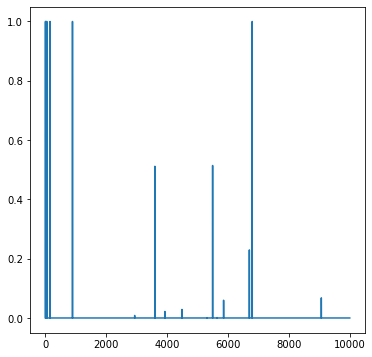

In [77]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x_marg, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


#### And the non-marginalized posterior

  MCMC sample 1000, loss = 25.88100788726305, a = 0.0
  MCMC sample 2000, loss = 25.88100788726305, a = 0.0
  MCMC sample 3000, loss = 25.88100788726305, a = 0.0
  MCMC sample 4000, loss = 25.88100788726305, a = 0.0
  MCMC sample 5000, loss = 25.88100788726305, a = 4.627431264963374e-40
  MCMC sample 6000, loss = 23.6882251400898, a = 0.0
  MCMC sample 7000, loss = 27.121473108149534, a = 0.0
  MCMC sample 8000, loss = 28.16228861235888, a = 0.0
  MCMC sample 9000, loss = 28.16228861235888, a = 0.0
[-0.99930683 -0.74780144]
[-1.16433701 -0.03086803]
[-1.00354521 -0.02539831]


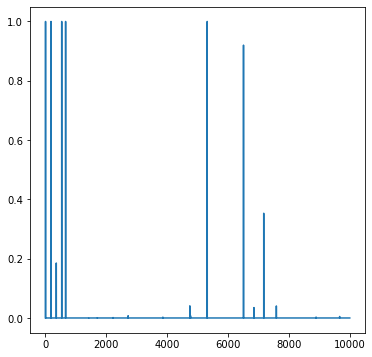

In [79]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


In [ ]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x1" : x[1]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x0, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)

print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)

  MCMC sample 1000, loss = 20.096447559446965, a = 0.0
  MCMC sample 2000, loss = 19.893191872065827, a = 0.0
  MCMC sample 3000, loss = 20.115855208412285, a = 1.5607872830341692e-292
  MCMC sample 4000, loss = 19.798134256535917, a = 4.7651929051322586e-48
  MCMC sample 5000, loss = 24.42035907678573, a = 1.3570267197099581e-238
  MCMC sample 6000, loss = 21.61640218454506, a = 1.4637480281381693e-105
  MCMC sample 7000, loss = 20.51647061706627, a = 3.0964764602575038e-133
  MCMC sample 8000, loss = 20.4131940904419, a = 1.636252248467269e-54
  MCMC sample 9000, loss = 19.80854419186002, a = 1.7400047319959545e-218
  MCMC sample 10000, loss = 19.960353358529225, a = 1.3139238275836357e-104


In [ ]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x0" : x[0]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x1, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


In [ ]:
logPi(x, z, y, sigma, alpha)


In [ ]:
logPi(jnp.array([x[0],x[1]]), z, y, sigma, alpha)

In [ ]:
logPi(jnp.array([x[1],x[1]]), z, y, sigma, alpha)

In [ ]:
x

In [ ]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [ ]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

In [ ]:
plt.imshow((myf_xy)); plt.colorbar()

In [ ]:
plt.imshow((myf_xy)); plt.colorbar()

In [ ]:
jnp.log(8) + jnp.log(4)

In [544]:
#plt.imshow(jnp.abs(myf_xy0-myf_xy2)); plt.colorbar()

In [545]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

01 7.10617168705603
00 -1380.0548486543553
11 -3204.012669532237
10 -4591.173689873648


In [546]:
myf(x[0],x[1])

DeviceArray(7.10617169, dtype=float64)

In [547]:
jnp.max(myf_xy)

DeviceArray(7.11481386, dtype=float64)

### Now sample z

In [548]:
z.shape

(10,)

In [549]:
x

DeviceArray([-1.10442216,  1.03766651], dtype=float64)

In [511]:
z[3]

DeviceArray(0, dtype=int64)

0.5
0.2


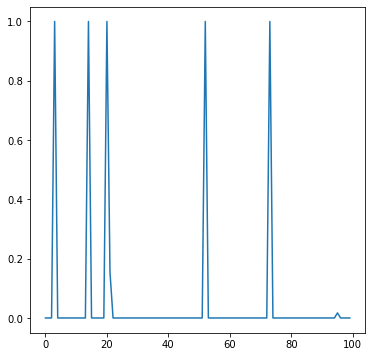

In [585]:
N_samples_z = 101
z0 = jnp.array(np.random.randint(0, K, (N,)))
#z0 = random.categorical(subkey, jnp.log(pi), shape = (N,))
#z0 = z.at[3].set(1)

#z0 = z0.at[0].set(0)
#z0 = z0.at[1].set(0)
B = 3

#params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : 3}
params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

key, subkey = random.split(key)
z_mean, z_r, z_samples = mcmc(subkey, proposal_z, z0, N_samples_z, params_z, 1, 1)
z_rec = z_samples[N_samples_z-2]
z_rec_m = jnp.mean(z_samples, axis=0)

plt.plot(z_r)
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec-z))/N)


In [586]:
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec_m-z))/N)

0.5
0.269


In [587]:
idx = 3
print(z0[idx])
print(z_rec[idx])
print(z[idx])

0
1
0


In [588]:
print(z0)
print(jnp.mean(z_samples, axis=0))
print(z)


[0 1 0 0 1 1 0 1 1 1]
[0.   0.52 0.54 0.48 0.14 0.41 0.   0.24 0.94 0.62]
[0 0 1 0 0 0 0 0 1 1]


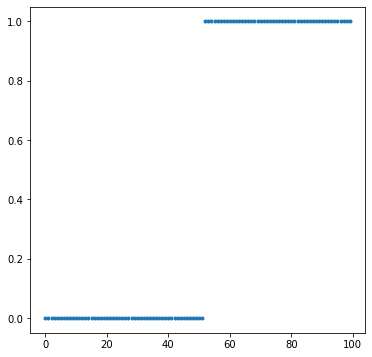

In [589]:
plt.plot(z_samples[:,3], '.')

In [590]:
z[3]

DeviceArray(0, dtype=int64)

In [591]:
x

DeviceArray([-1.10442216,  1.03766651], dtype=float64)

In [592]:
jnp.exp(-(y[3] - x[0])**2/sigma)

DeviceArray(0.99993831, dtype=float64)

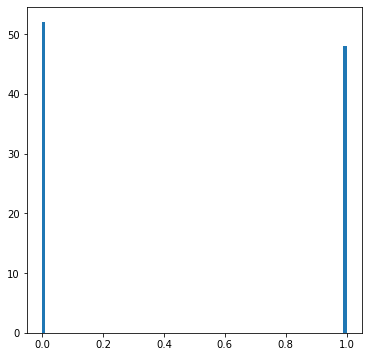

In [593]:
nbins=100
counts, bins = np.histogram(z_samples[:,3], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [594]:
print(z0)
print(z_rec)
print(z)

[0 1 0 0 1 1 0 1 1 1]
[0 0 1 1 0 1 0 0 1 1]
[0 0 1 0 0 0 0 0 1 1]
